## Student Dropout and Academic Success Prediction

### 1. Problem Statement


Student dropout rates are a persistent problem in all learning institutions. The effects of a student dropping out have far reaching consequences beyond them as an individual - institutions lose tuition revenue and funding, governments see diminished returns on public investment in education, and societies forfeit the long-term economic and social contributions of a skilled graduate.

Interestngly, students who drop out typically show early warning signals across academic performance, attendance patterns, engagement levels, and socio-economic factors. However, these signals are often identified too late or assessed subjectively, limiting the effectiveness of timely interventions by the learning institution.

This project proposes the use of supervised machine learning to develop a classification model that is able to identify high-risk students before it is too late. The central aim is to enable timely interventions by academic advisors and the student support office.


### 2. Importing Libraries & Data

In [64]:
# import all basic libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as mn


In [65]:
#importing the dataset from UCI ML repo

from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
predict_students_dropout_and_academic_success = fetch_ucirepo(id=697) 
  
# data (as pandas dataframes) 
X = predict_students_dropout_and_academic_success.data.features 
y = predict_students_dropout_and_academic_success.data.targets 
  
# metadata 
#print(predict_students_dropout_and_academic_success.metadata) 
  
# variable information 
#print(predict_students_dropout_and_academic_success.variables) 


### 3. Exploratory Data Analysis

In [66]:
#for EDA merge the features and target dataframes
data=pd.concat([X,y],axis=1)
data.head()

,Marital Status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


#### 3.1 Handle missingness

In [67]:
data.isnull().sum()

Marital Status                                    0
Application mode                                  0
Application order                                 0
Course                                            0
Daytime/evening attendance                        0
Previous qualification                            0
Previous qualification (grade)                    0
Nacionality                                       0
Mother's qualification                            0
Father's qualification                            0
Mother's occupation                               0
Father's occupation                               0
Admission grade                                   0
Displaced                                         0
Educational special needs                         0
Debtor                                            0
Tuition fees up to date                           0
Gender                                            0
Scholarship holder                                0
Age at enrol

<Axes: >

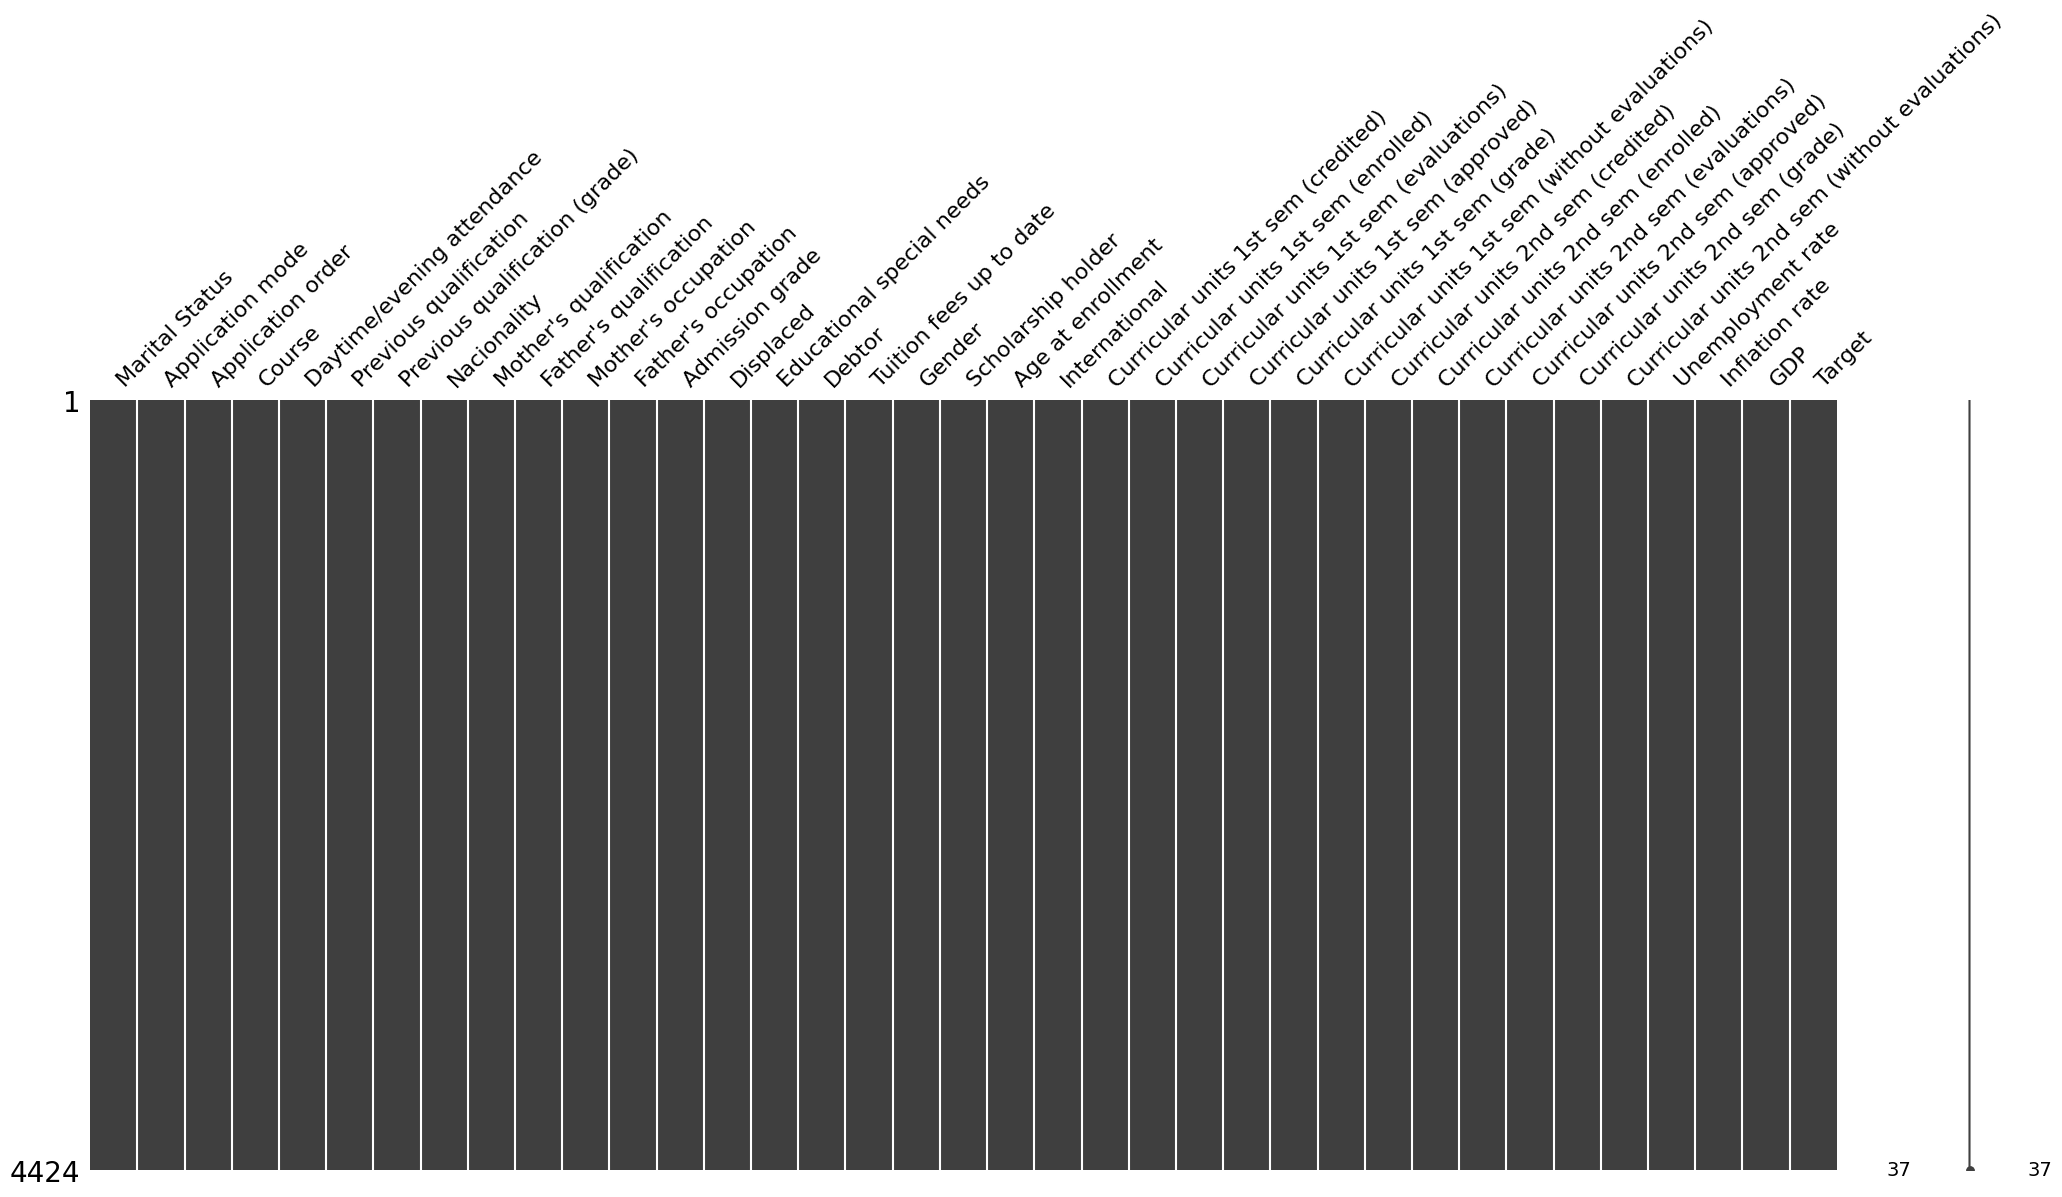

In [68]:
mn.matrix(data)

In [69]:
# look out for duplicates
data.duplicated().sum()

np.int64(0)

There is no missingness and there is no duplicated data. Therefore we can move to EDA confidently.

##### 1. There are no significant differenes in admission grades across the 3 classes.

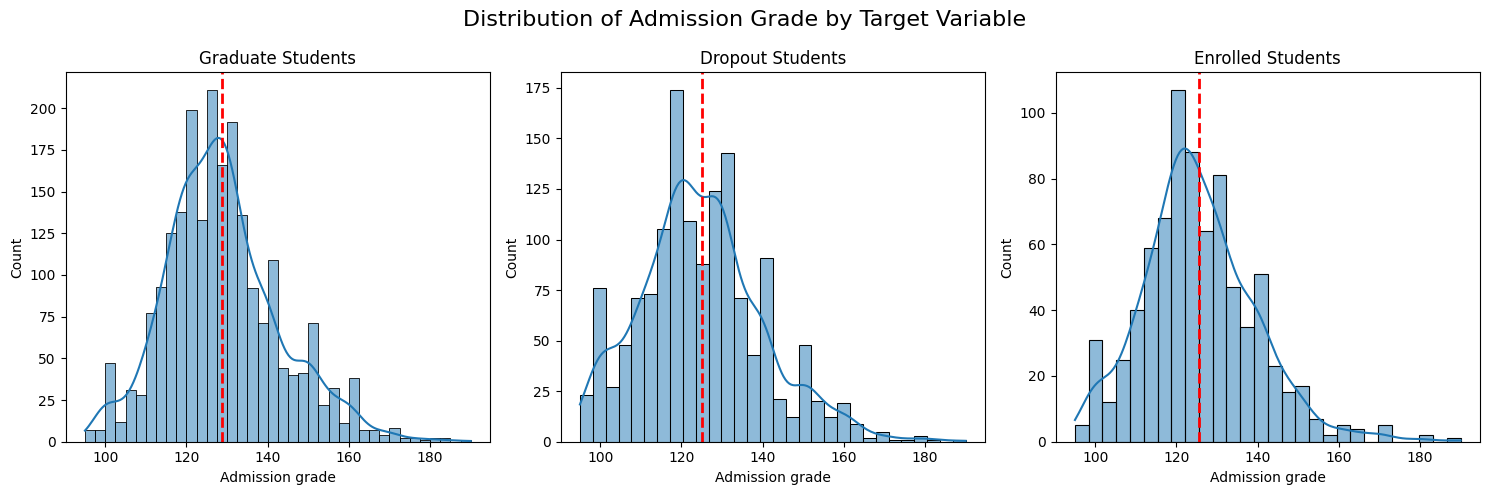

In [70]:
plt.figure(figsize=(15,5))
plt.suptitle('Distribution of Admission Grade by Target Variable', fontsize=16)

plt.subplot(1,3,1)
grad_data=data[data['Target']=='Graduate']
sns.histplot(data=grad_data,x='Admission grade',kde=True)
plt.axvline(grad_data['Admission grade'].mean(), linestyle='--',color='red',linewidth=2)
plt.title('Graduate Students')

plt.subplot(1,3,2)
drop_data=data[data['Target']=='Dropout']
sns.histplot(data=drop_data,x='Admission grade',kde=True)
plt.axvline(drop_data['Admission grade'].mean(), linestyle='--',color='red',linewidth=2)
plt.title('Dropout Students')

plt.subplot(1,3,3)
enrol_data=data[data['Target']=='Enrolled']
sns.histplot(data=enrol_data,x='Admission grade',kde=True)
plt.axvline(enrol_data['Admission grade'].mean(), linestyle='--',color='red',linewidth=2)
plt.title('Enrolled Students')

plt.tight_layout()
plt.show()

##### 2. There is a difference in the median age of enrollment across the classes. Students who graduate appear to enrol in school at an earlier age (<20 years), while dropouts enrol at about 23 years. This signals that age of enrolment could be a predictor of student outcomes.

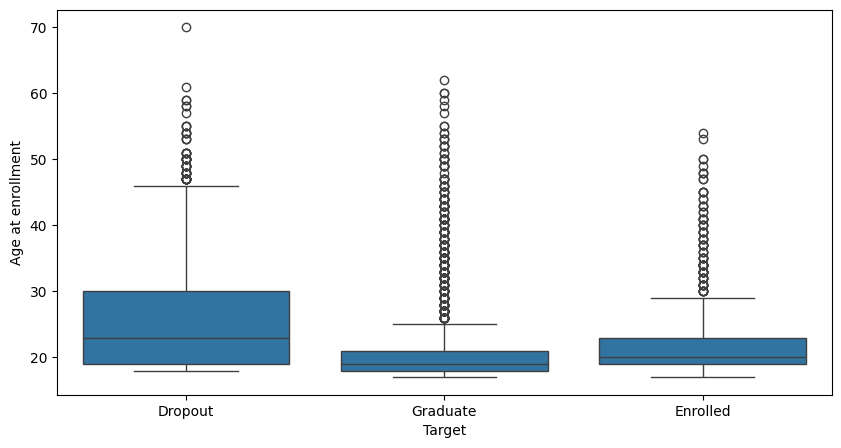

In [71]:
plt.figure(figsize=(10,5))
sns.boxplot(data=data,x='Target',y='Age at enrollment')
plt.show()

##### 3. There is no clear connecting between students who chose the school as a first choice and their graduation outcomes.

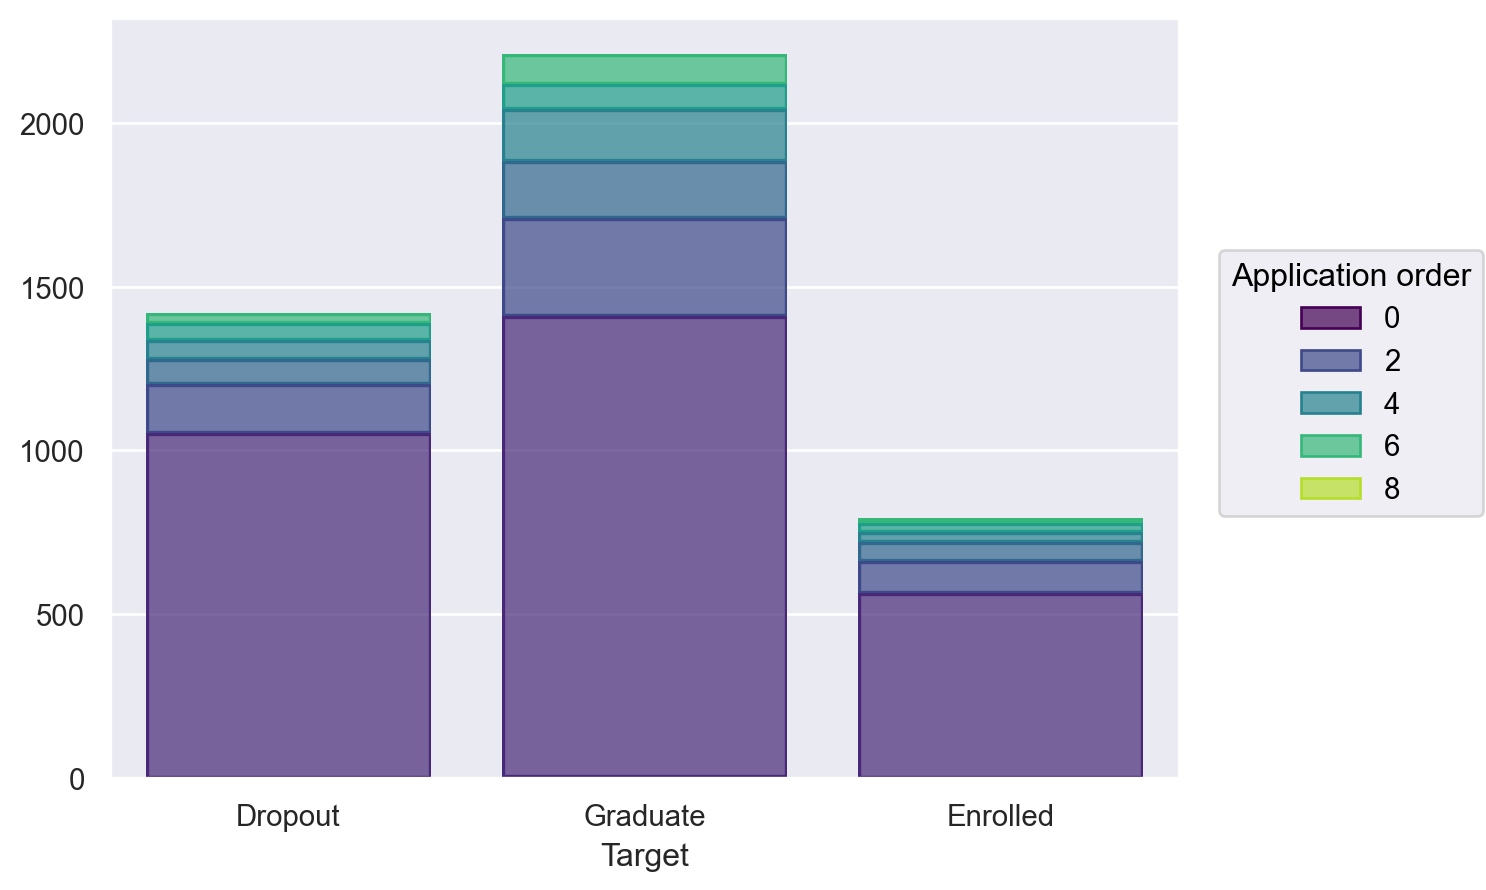

In [72]:
import seaborn.objects as so

(
    so.Plot(
        data=data,
        x="Target",
        color="Application order"
    )
    .add(so.Bar(), so.Count(), so.Stack())
    .scale(color="viridis")
)

##### 4. Do some courses have higher dropout rates?

In [73]:
#to make interpretation easier, add labels to the courses

course_map = {
    33:   "Biofuel Production Technologies",
    171:  "Animation and Multimedia Design",
    8014: "Social Service (evening attendance)",
    9003: "Agronomy",
    9070: "Communication Design",
    9085: "Veterinary Nursing",
    9119: "Informatics Engineering",
    9130: "Equinculture",
    9147: "Management",
    9238: "Social Service",
    9254: "Tourism",
    9500: "Nursing",
    9556: "Oral Hygiene",
    9670: "Advertising and Marketing Management",
    9773: "Journalism and Communication",
    9853: "Basic Education",
    9991: "Management (evening attendance)",
}

data["Course Name"] = data["Course"].map(course_map)


##### 5. There is no clear connection between a course a student takes and their academic outcomes.

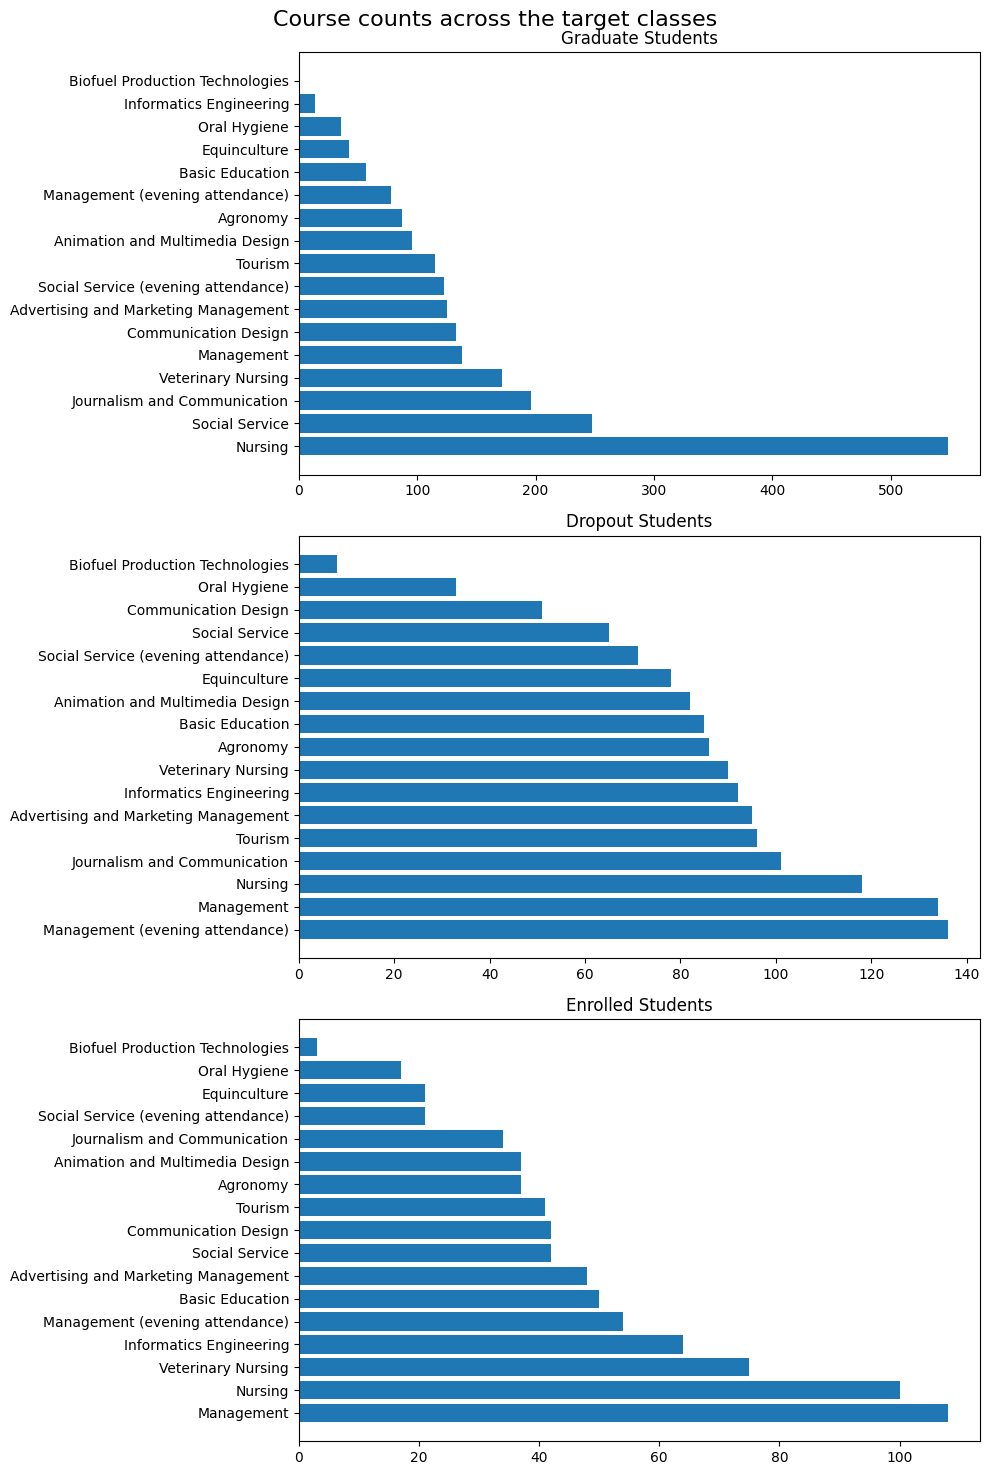

In [78]:
plt.figure(figsize=(10,15))
plt.suptitle('Course counts across the target classes', fontsize=16)

plt.subplot(3,1,1)
grad_data=data[data['Target']=='Graduate']
plt.barh(grad_data['Course Name'].value_counts().index, grad_data['Course Name'].value_counts().values)
plt.title('Graduate Students')

plt.subplot(3,1,2)
drop_data=data[data['Target']=='Dropout']
plt.barh(drop_data['Course Name'].value_counts().index, drop_data['Course Name'].value_counts().values)
plt.title('Dropout Students')

plt.subplot(3,1,3)
enrol_data=data[data['Target']=='Enrolled']
plt.barh(enrol_data['Course Name'].value_counts().index, enrol_data['Course Name'].value_counts().values)
plt.title('Enrolled Students')

plt.tight_layout()

##### 6. There are more women enrolled than men, and more women are graduating. However, it is an almost 50-50 split for dropouts.

In [79]:
gender_map = {1: "Male", 0: "Female"}
data["Gender Label"] = data["Gender"].map(gender_map)

Text(0.5, 1.0, 'Dropout')

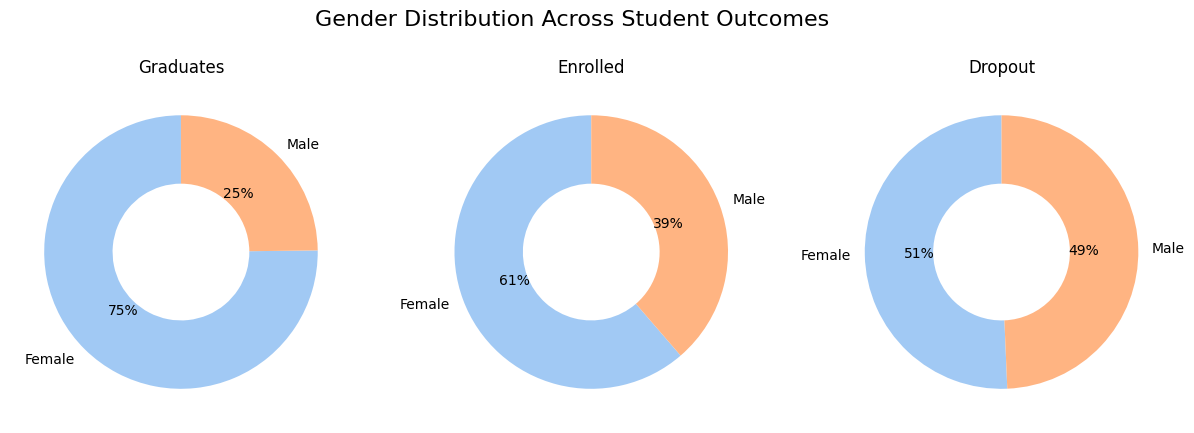

In [86]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
plt.suptitle('Gender Distribution Across Student Outcomes', fontsize=16)

ax1 = ax[0]
grad_data = data[data["Target"] == "Graduate"]
counts = grad_data["Gender Label"].value_counts()
wedges, texts, autotexts = ax1.pie(
    counts.values,       
    labels=counts.index, 
    colors=sns.color_palette("pastel"),
    startangle=90,
    autopct="%.0f%%",
    wedgeprops=dict(width=0.5)
)
ax1.set_title("Graduates")


ax2 = ax[1]
enrol_data = data[data["Target"] == "Enrolled"]
counts = enrol_data["Gender Label"].value_counts()
wedges, texts, autotexts = ax2.pie(
    counts.values,       
    labels=counts.index, 
    colors=sns.color_palette("pastel"),
    startangle=90,
    autopct="%.0f%%",
    wedgeprops=dict(width=0.5)
)
ax2.set_title("Enrolled")

ax3 = ax[2]
drop_data = data[data["Target"] == "Dropout"]
counts = drop_data["Gender Label"].value_counts()
wedges, texts, autotexts = ax3.pie(
    counts.values,       
    labels=counts.index, 
    colors=sns.color_palette("pastel"),
    startangle=90,
    autopct="%.0f%%",
    wedgeprops=dict(width=0.5)
)
ax3.set_title("Dropout")


##### 7. There is some class imbalance.

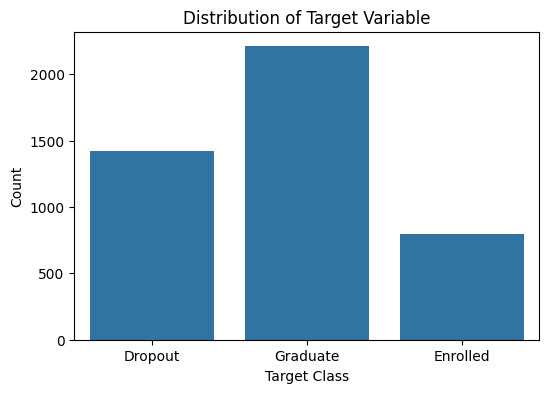

In [ ]:
# distribution of target variable

plt.figure(figsize=(6,4))
sns.countplot(x='Target',data=data)

plt.title('Distribution of Target Variable')
plt.ylabel('Count')
plt.show()

#### 8. Correlation Matrix

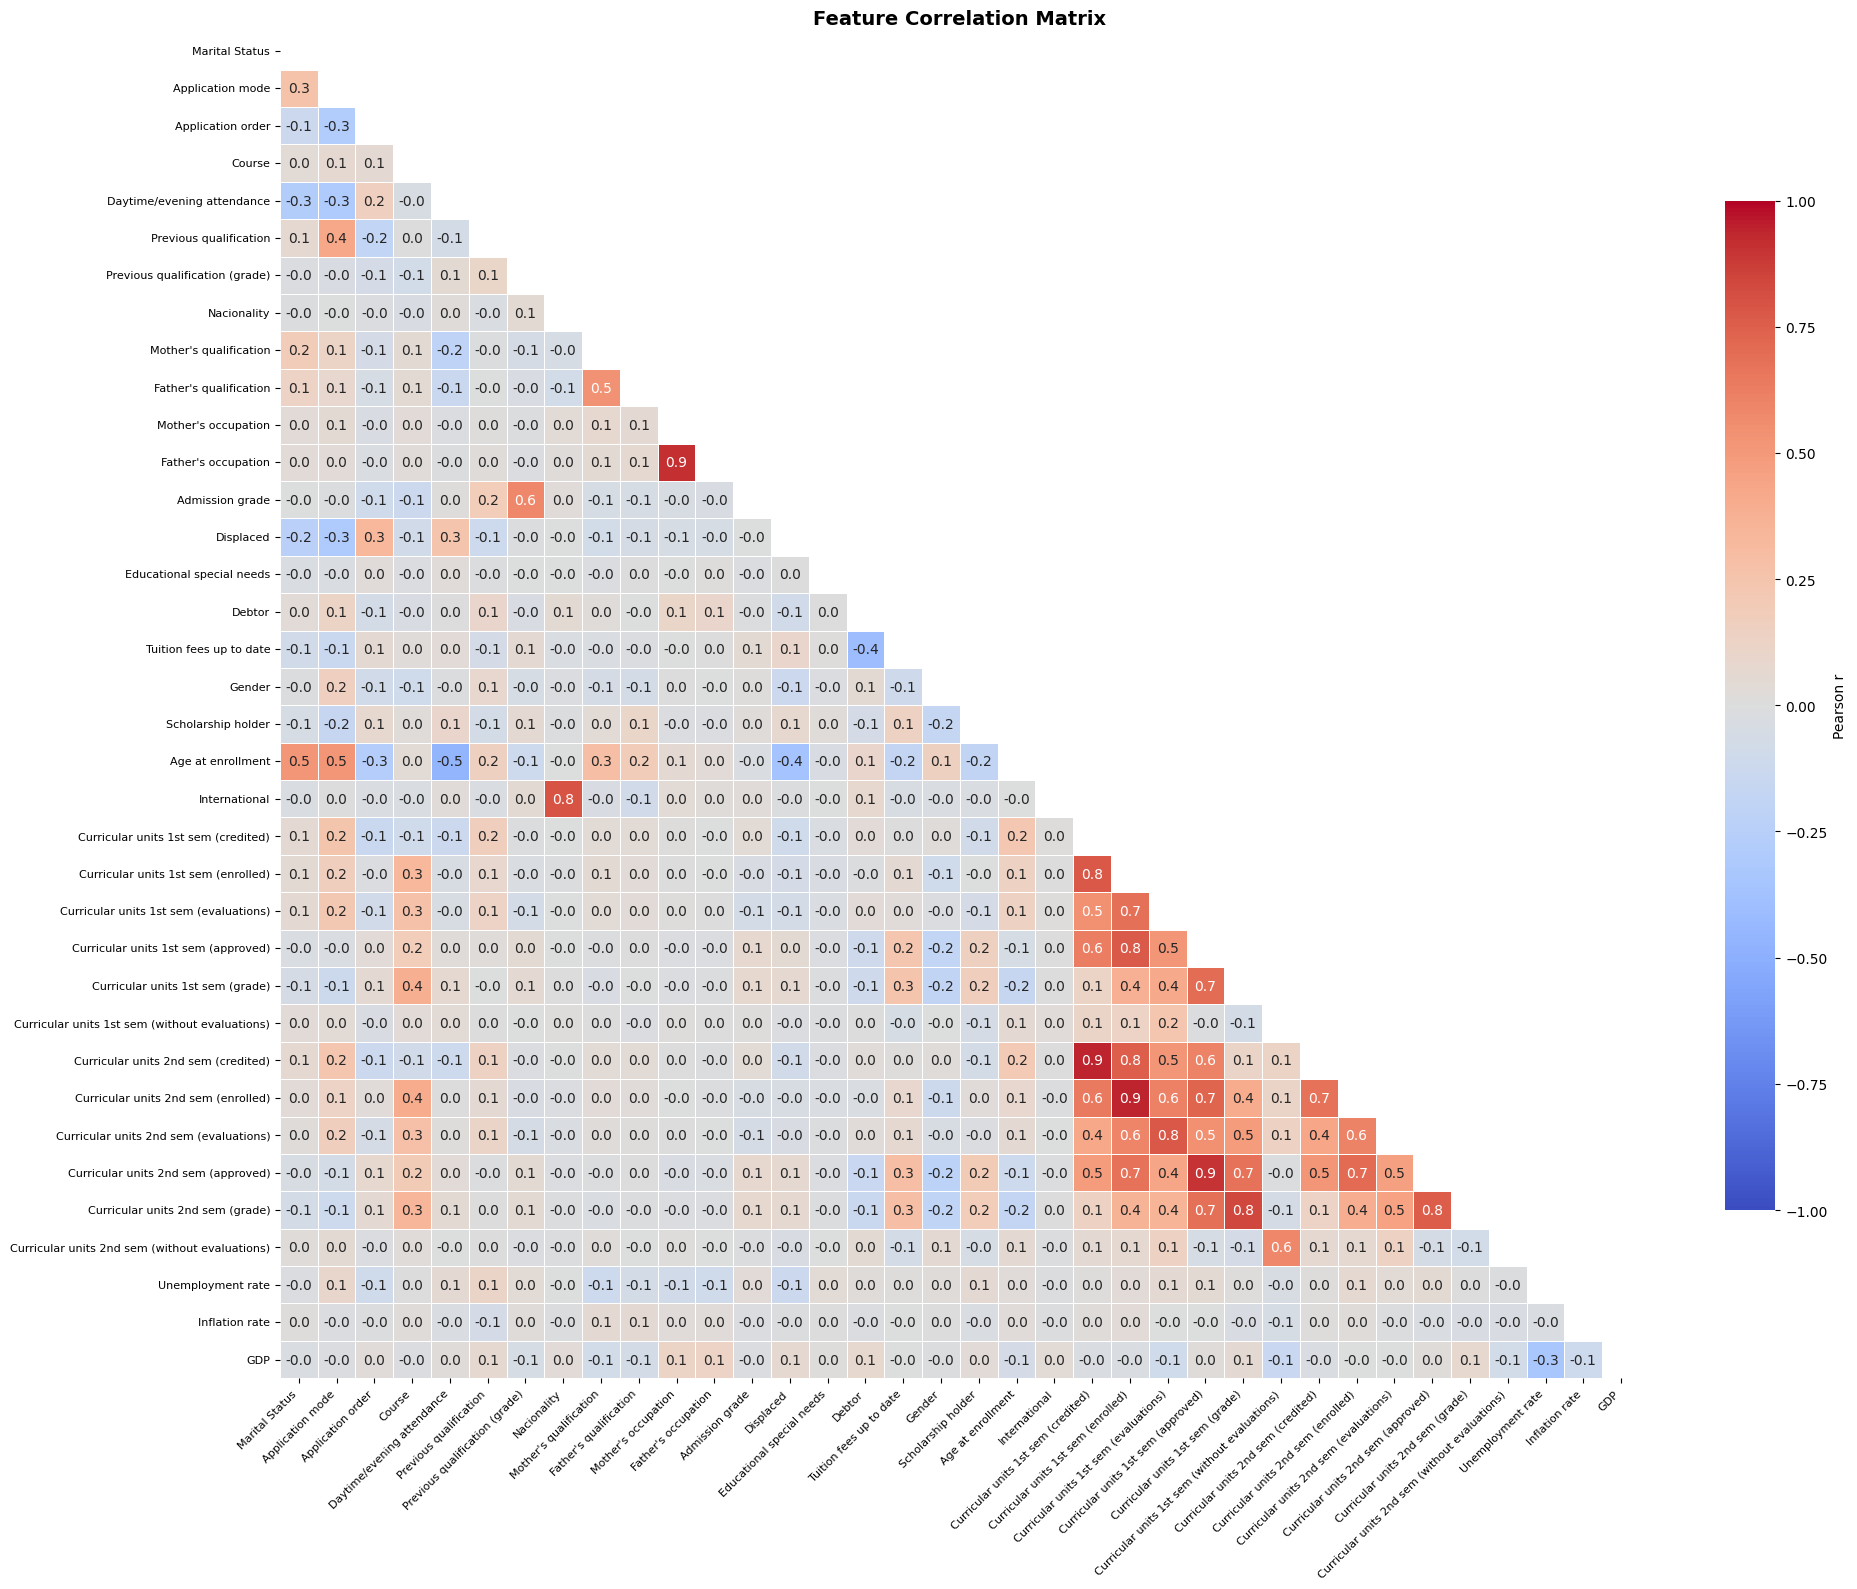

In [87]:
#only plot numerical features for correlation analysis
numeric_df = data.select_dtypes(include=np.number)

corr = numeric_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

fig, ax = plt.subplots(figsize=(20, 16))
sns.heatmap(
    corr,
    mask=mask,
    cmap="coolwarm",   
    center=0,          
    vmin=-1, vmax=1,
    annot=True,        
    fmt=".1f",         
    linewidths=0.4,
    cbar_kws={"shrink": 0.75, "label": "Pearson r"},
    ax=ax
)

ax.set_title("Feature Correlation Matrix", fontsize=14, fontweight="bold")
plt.xticks(rotation=45, ha="right", fontsize=8)
plt.yticks(fontsize=8)

plt.tight_layout()
plt.show()

#### 9. Linear separability

There are 35 features, plotting a pairplot with all these features would make it very hard to interpret. Instead, I just used a few meaningful features - also this way the pairplot does not take so long to plot.

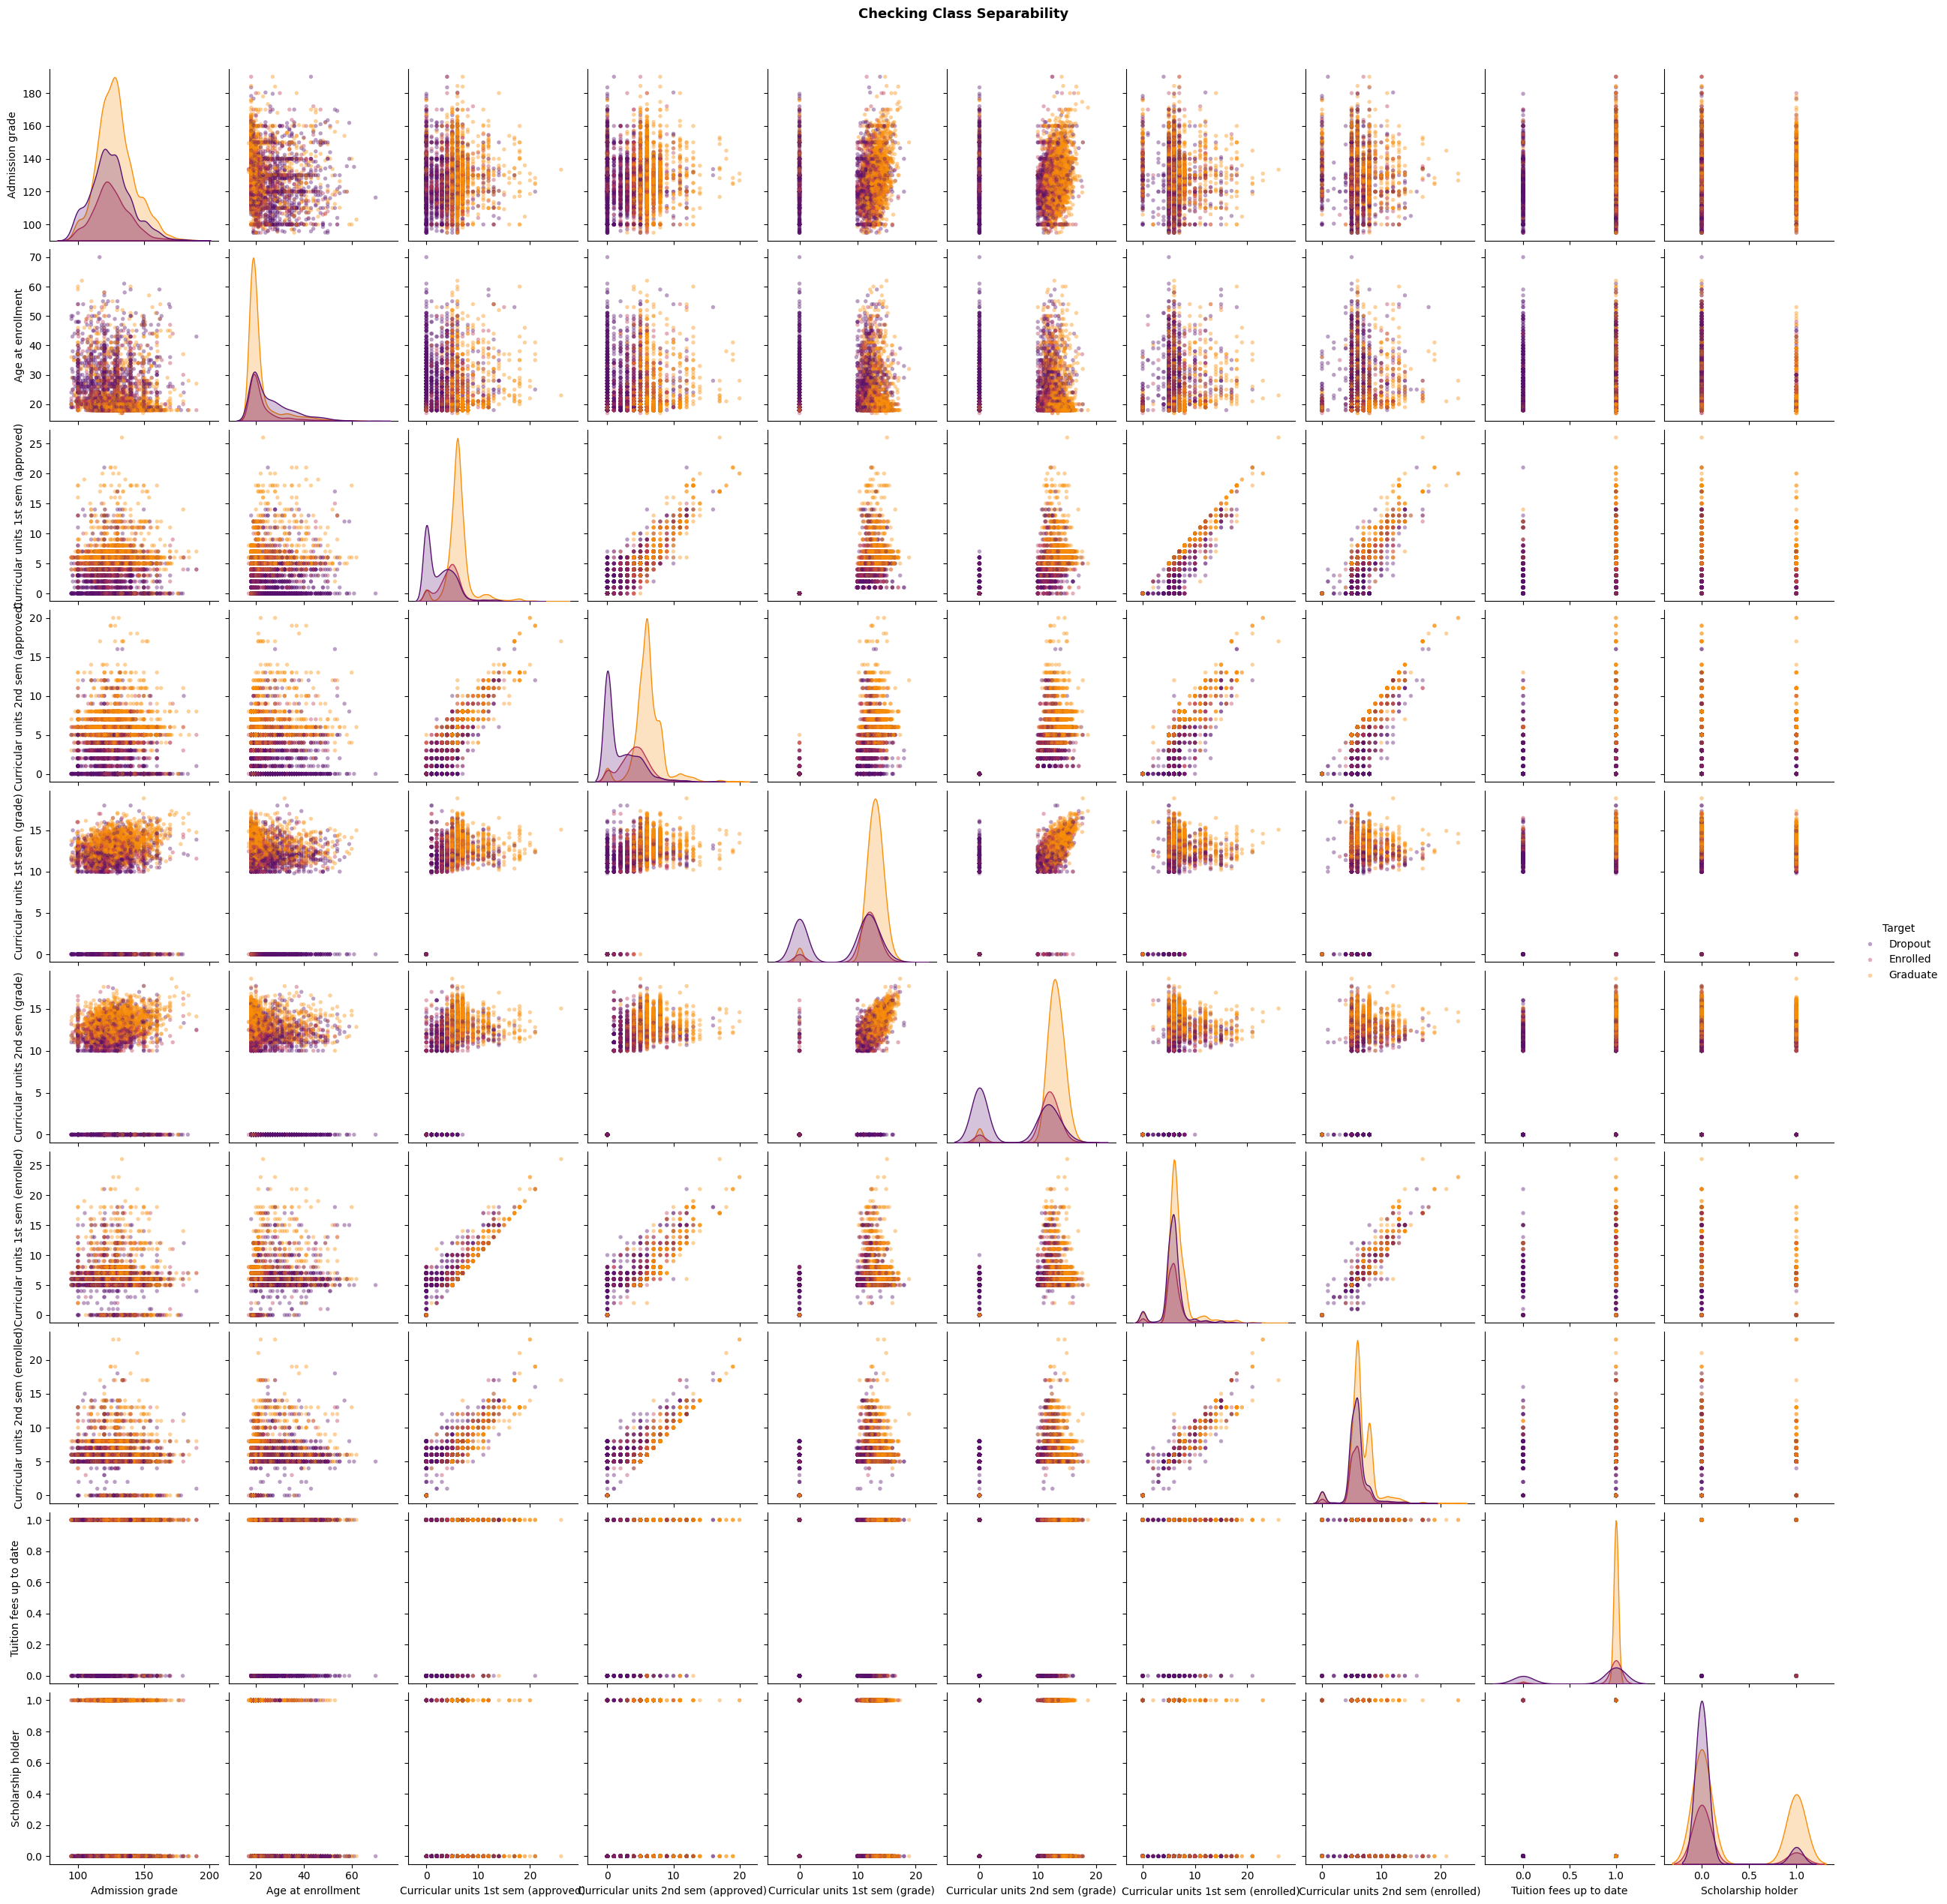

In [93]:
cols = [
    "Admission grade",
    "Age at enrollment",
    "Curricular units 1st sem (approved)",
    "Curricular units 2nd sem (approved)",
    "Curricular units 1st sem (grade)",
    "Curricular units 2nd sem (grade)",
    "Curricular units 1st sem (enrolled)",
    "Curricular units 2nd sem (enrolled)",
    "Tuition fees up to date",
    "Scholarship holder",
    "Target"
]

pair_df = data[cols]

sns.pairplot(
    pair_df,
    hue="Target",
    palette='inferno',
    hue_order=["Dropout", "Enrolled", "Graduate"],
    diag_kind="kde",
    plot_kws={"alpha": 0.4, "s": 15, "edgecolor": "none"}
)

plt.suptitle("Checking Class Separability", y=1.02, fontsize=13, fontweight="bold")
plt.show()

### 4. Data Preprocessing

#### 4.1 Identifying imbalanced data

In [94]:
print(data['Target'].value_counts())

Target
Graduate    2209
Dropout     1421
Enrolled     794
Name: count, dtype: int64


The dataset is not severely imbalanced- no need for SMOTE. 

In [96]:
#drop the columns added during EDA
data.drop(columns=['Course Name', 'Gender Label'], inplace=True)

There is also no feature encoding step needed since all data was originally numerical, next is splitting the data into the original train-test split and modeling.

#### 5. Modelling with Preprocessed Data

In [99]:
X=data.drop('Target',axis=1)
y=data[['Target']]

In [100]:
#Train Test Split: Reserve 30% of data for final model testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split (X, y, test_size=0.20, random_state=20)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(3539, 36) (885, 36) (3539, 1) (885, 1)


In [101]:
#scale the features

from sklearn.preprocessing import MinMaxScaler,RobustScaler, StandardScaler
scaler = RobustScaler()
X_train= scaler.fit_transform(X_train)
X_test= scaler.transform(X_test)

In [ ]:
#classification with random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import fbeta_score

rf = RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42) 
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(
    rf,            
    X_train,       
    y_train,        
    cv=cv,         
    scoring="f1_macro"  
)
print(f"Cross-validated F1 Macro scores: {scores}")

d:\Student_Outcomes_Prediction\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
d:\Student_Outcomes_Prediction\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
d:\Student_Outcomes_Prediction\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
d:\Student_Outcomes_Prediction\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. P

Cross-validated F1 Macro scores: [0.668899   0.68250148 0.68950489 0.68471009 0.68036414]


In [104]:
#classification with SVM
from sklearn.svm import SVC


svm_rbf=SVC(kernel='rbf',gamma='scale',class_weight='balanced',random_state=40)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(
    svm_rbf,            
    X_train,        
    y_train,        
    cv=cv,          
    scoring="f1_macro"  
)
print(f"Cross-validated F1 Macro scores: {scores}")

d:\Student_Outcomes_Prediction\.venv\Lib\site-packages\sklearn\utils\validation.py:1352: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\Student_Outcomes_Prediction\.venv\Lib\site-packages\sklearn\utils\validation.py:1352: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\Student_Outcomes_Prediction\.venv\Lib\site-packages\sklearn\utils\validation.py:1352: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\Student_Outcomes_Prediction\.venv\Lib\site-packages\sklearn\utils\validation.py:1352: DataConversionWarning: A column-vector y was passed when a 1d array was expec

Cross-validated F1 Macro scores: [0.63903882 0.62462618 0.6304214  0.65105206 0.67980751]


In [105]:
svm_rbf=SVC(kernel='poly',degree=3,class_weight='balanced',random_state=40)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(
    svm_rbf,            
    X_train,        
    y_train,        
    cv=cv,          
    scoring="f1_macro"  
)
print(f"Cross-validated F1 Macro scores: {scores}")

d:\Student_Outcomes_Prediction\.venv\Lib\site-packages\sklearn\utils\validation.py:1352: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\Student_Outcomes_Prediction\.venv\Lib\site-packages\sklearn\utils\validation.py:1352: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\Student_Outcomes_Prediction\.venv\Lib\site-packages\sklearn\utils\validation.py:1352: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\Student_Outcomes_Prediction\.venv\Lib\site-packages\sklearn\utils\validation.py:1352: DataConversionWarning: A column-vector y was passed when a 1d array was expec

Cross-validated F1 Macro scores: [0.48365394 0.48723556 0.47601111 0.47075015 0.48849159]


In [107]:
from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoostClassifier(n_estimators=100, learning_rate=1.0, random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Step 3 — run cross validation
scores = cross_val_score(
    ada,
    X_train,
    y_train,
    cv=cv,
    scoring="f1_macro"
)

print(f"Cross-validated F1 Macro scores: {scores}")


d:\Student_Outcomes_Prediction\.venv\Lib\site-packages\sklearn\utils\validation.py:1352: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\Student_Outcomes_Prediction\.venv\Lib\site-packages\sklearn\utils\validation.py:1352: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\Student_Outcomes_Prediction\.venv\Lib\site-packages\sklearn\utils\validation.py:1352: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\Student_Outcomes_Prediction\.venv\Lib\site-packages\sklearn\utils\validation.py:1352: DataConversionWarning: A column-vector y was passed when a 1d array was expec

Cross-validated F1 Macro scores: [0.66659847 0.65419185 0.67403129 0.65697187 0.67071151]


The random forest classifier is the best performing one.